In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

# Dependency imports
from absl import flags
import matplotlib
import numpy as np
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import pickle 

from models.bayesian_resnet import bayesian_resnet
from models.bayesian_vgg import bayesian_vgg

matplotlib.use("Agg")
warnings.simplefilter(action="ignore")
tfd = tfp.distributions

IMAGE_SHAPE = [32, 32, 3]

In [4]:
def build_input_pipeline(x_train, x_test, y_train, y_test,
                         batch_size, valid_size):
  """Build an Iterator switching between train and heldout data."""
  x_train = x_train.astype("float32")
  x_test = x_test.astype("float32")

  x_train /= 255
  x_test /= 255

  y_train = y_train.flatten()
  y_test = y_test.flatten()

  if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

  print("x_train shape:" + str(x_train.shape))
  print(str(x_train.shape[0]) + " train samples")
  print(str(x_test.shape[0]) + " test samples")

  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, np.int32(y_train)))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)

  # Build a iterator over the heldout set with batch_size=heldout_size,
  # i.e., return the entire heldout set as a constant.
  heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (x_test, np.int32(y_test)))
  heldout_batches = heldout_dataset.repeat().batch(valid_size)
  heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_batches)

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.compat.v1.placeholder(tf.string, shape=[])
  feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  images, labels = feedable_iterator.get_next()

  return images, labels, handle, training_iterator, heldout_iterator

In [5]:
def build_fake_data(num_examples):
  """Build fake CIFAR10-style data for unit testing."""
  num_examples = num_examples
  x_train = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_train = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  x_test = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_test = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  return (x_train, y_train), (x_test, y_test)

In [6]:
model_dir = "bnnmodels/"
loss_dir = 'lossesFAKE/'

### Hyperparams

In [7]:
#Generate fake data for now before switching to CIFAR10
fake_data = True
#batch_size = 128
data_dir = "data/"
eval_freq = 400
num_monte_carlo = 50
architecture = "resnet" # or "vgg"
kernel_posterior_scale_mean = 0.9
kernel_posterior_scale_constraint = 0.2
kl_annealing = 50
subtract_pixel_mean = True

In [8]:
from IPython.core.debugger import set_trace

In [77]:
def run_experiment(algo,fake_data, batch_size, epochs, learning_rate,verbose):
    with tf.Session() as sess:
        
        model_fn = bayesian_resnet
        #model_fn = bayesian_vgg
        model = model_fn(
            IMAGE_SHAPE,
            num_classes=10,
            kernel_posterior_scale_mean=kernel_posterior_scale_mean,
            kernel_posterior_scale_constraint=kernel_posterior_scale_constraint)
        logits = model(images)
        labels_distribution = tfd.Categorical(logits=logits)
        t = tf.compat.v2.Variable(0.0)
        kl_regularizer = t / (kl_annealing * len(x_train) / batch_size)

        log_likelihood = labels_distribution.log_prob(labels)
        neg_log_likelihood = -tf.reduce_mean(input_tensor=log_likelihood)
        kl = sum(model.losses) / len(x_train) * tf.minimum(1.0, kl_regularizer)
        loss = neg_log_likelihood + kl

        predictions = tf.argmax(input=logits, axis=1)

        with tf.compat.v1.name_scope("train"):
            train_accuracy, train_accuracy_update_op = tf.compat.v1.metrics.accuracy(
              labels=labels, predictions=predictions)
            if algo=="adam":
                opt = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            if algo=="adagrad":
                opt = tf.compat.v1.train.AdagradOptimizer(learning_rate=learning_rate)
            if algo=="adadelta":
                opt = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=learning_rate)
            if algo=="rmsprop":
                opt = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learning_rate)

            train_op = opt.minimize(loss)
            update_step_op = tf.compat.v1.assign(t, t + 1)

        with tf.compat.v1.name_scope("valid"):
            valid_accuracy, valid_accuracy_update_op = tf.compat.v1.metrics.accuracy(
              labels=labels, predictions=predictions)

            init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                           tf.compat.v1.local_variables_initializer())

            stream_vars_valid = [v for v in tf.compat.v1.local_variables() if "valid/" in v.name]
            reset_valid_op = tf.compat.v1.variables_initializer(stream_vars_valid)
    
    
   # with tf.compat.v1.Session() as sess:
        sess.run(init_op)

        # Run the training loop
        train_handle = sess.run(training_iterator.string_handle())
        heldout_handle = sess.run(heldout_iterator.string_handle())
        training_steps = int(
          round(epochs * (len(x_train) / batch_size)))
        
        listkl = []
        listloss = []
        listaccuracy = []
        print(training_steps)
        for step in range(training_steps):
            _ = sess.run([train_op,
                      train_accuracy_update_op,
                      update_step_op],
                     feed_dict={handle: train_handle})
            # Print loss values
            #set_trace()
            loss_value, accuracy_value, kl_value = sess.run(
                  [loss, train_accuracy, kl], feed_dict={handle: train_handle})
            if step % 100 == 0:
                print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f} KL: {:.3f}".format(
                      step, loss_value, accuracy_value, kl_value))
            listkl.append(kl_value)
            listloss.append(loss_value)
            listaccuracy.append(accuracy_value)
        sess.run(reset_valid_op)
        

    return listloss,listkl
    

In [61]:
num_examples = 10
batch_size = 1

In [62]:
with tf.Session() as sess:
    if fake_data:
        (x_train, y_train), (x_test, y_test) = build_fake_data(num_examples)
    else:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    (images, labels, handle,
     training_iterator,
     heldout_iterator) = build_input_pipeline(x_train, x_test, y_train, y_test,
                                              batch_size, 500)

x_train shape:(10, 32, 32, 3)
10 train samples
10 test samples


In [63]:
epochs = 60
nb_runs = 5
seed0 = 23456

### ADAM

In [64]:
lr_adam = 0.001

In [65]:
adam_loss = []
adam_kl = []
for _ in range(nb_runs):
    print("Run Number: {:.3f}".format(_))
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adam', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adam, 
                         verbose= True)
    adam_loss.append(loss)
    adam_kl.append(kl)

600
Step:   0 Loss: 273507.312 Accuracy: 0.000 KL: 1199.538
Step:   1 Loss: 2399.802 Accuracy: 0.000 KL: 2399.802
Step:   2 Loss: 292096.812 Accuracy: 0.000 KL: 3600.322
Step:   3 Loss: 319001.469 Accuracy: 0.000 KL: 4801.079
Step:   4 Loss: 179433.391 Accuracy: 0.000 KL: 6002.042
Step:   5 Loss: 477434.406 Accuracy: 0.167 KL: 7203.177
Step:   6 Loss: 75657.945 Accuracy: 0.143 KL: 8404.478
Step:   7 Loss: 221889.656 Accuracy: 0.125 KL: 9605.904
Step:   8 Loss: 39793.477 Accuracy: 0.111 KL: 10807.453
Step:   9 Loss: 61089.203 Accuracy: 0.100 KL: 12009.107
Step:  10 Loss: 427954.750 Accuracy: 0.182 KL: 13210.847
Step:  11 Loss: 203989.406 Accuracy: 0.250 KL: 14412.667
Step:  12 Loss: 80475.656 Accuracy: 0.231 KL: 15614.557
Step:  13 Loss: 312627.375 Accuracy: 0.214 KL: 16816.516
Step:  14 Loss: 217437.375 Accuracy: 0.200 KL: 18018.535
Step:  15 Loss: 354579.625 Accuracy: 0.188 KL: 19220.607
Step:  16 Loss: 528235.375 Accuracy: 0.235 KL: 20422.723
Step:  17 Loss: 165809.094 Accuracy: 0.22

Step: 144 Loss: 183408.625 Accuracy: 0.097 KL: 174440.766
Step: 145 Loss: 234033.203 Accuracy: 0.096 KL: 175644.672
Step: 146 Loss: 290934.188 Accuracy: 0.095 KL: 176848.547
Step: 147 Loss: 268615.719 Accuracy: 0.095 KL: 178052.453
Step: 148 Loss: 270941.438 Accuracy: 0.094 KL: 179256.344
Step: 149 Loss: 184229.000 Accuracy: 0.093 KL: 180460.266
Step: 150 Loss: 349456.938 Accuracy: 0.093 KL: 181664.203
Step: 151 Loss: 248191.000 Accuracy: 0.092 KL: 182868.141
Step: 152 Loss: 309909.500 Accuracy: 0.092 KL: 184072.078
Step: 153 Loss: 225154.344 Accuracy: 0.091 KL: 185276.047
Step: 154 Loss: 262110.453 Accuracy: 0.090 KL: 186480.031
Step: 155 Loss: 323934.250 Accuracy: 0.090 KL: 187684.047
Step: 156 Loss: 188888.078 Accuracy: 0.089 KL: 188888.078
Step: 157 Loss: 194022.672 Accuracy: 0.089 KL: 190092.172
Step: 158 Loss: 249804.094 Accuracy: 0.088 KL: 191296.250
Step: 159 Loss: 221431.297 Accuracy: 0.087 KL: 192500.344
Step: 160 Loss: 277059.562 Accuracy: 0.087 KL: 193704.484
Step: 161 Loss

Step: 286 Loss: 370122.938 Accuracy: 0.084 KL: 345431.594
Step: 287 Loss: 393540.094 Accuracy: 0.083 KL: 346635.906
Step: 288 Loss: 363793.969 Accuracy: 0.083 KL: 347840.250
Step: 289 Loss: 365417.750 Accuracy: 0.086 KL: 349044.469
Step: 290 Loss: 379485.594 Accuracy: 0.086 KL: 350248.688
Step: 291 Loss: 380553.750 Accuracy: 0.086 KL: 351452.969
Step: 292 Loss: 401193.812 Accuracy: 0.085 KL: 352657.156
Step: 293 Loss: 355308.281 Accuracy: 0.085 KL: 353861.469
Step: 294 Loss: 439180.250 Accuracy: 0.085 KL: 355065.750
Step: 295 Loss: 391851.125 Accuracy: 0.084 KL: 356270.062
Step: 296 Loss: 357474.438 Accuracy: 0.084 KL: 357474.438
Step: 297 Loss: 399985.625 Accuracy: 0.084 KL: 358678.938
Step: 298 Loss: 380449.062 Accuracy: 0.084 KL: 359883.281
Step: 299 Loss: 361087.656 Accuracy: 0.083 KL: 361087.656
Step: 300 Loss: 378886.406 Accuracy: 0.086 KL: 362292.062
Step: 301 Loss: 378873.344 Accuracy: 0.086 KL: 363496.406
Step: 302 Loss: 400874.594 Accuracy: 0.086 KL: 364700.906
Step: 303 Loss

Step: 428 Loss: 524484.750 Accuracy: 0.077 KL: 516438.469
Step: 429 Loss: 542443.062 Accuracy: 0.077 KL: 517642.469
Step: 430 Loss: 539458.125 Accuracy: 0.077 KL: 518846.688
Step: 431 Loss: 521148.125 Accuracy: 0.076 KL: 520050.844
Step: 432 Loss: 569085.188 Accuracy: 0.076 KL: 521255.031
Step: 433 Loss: 528924.625 Accuracy: 0.076 KL: 522459.219
Step: 434 Loss: 528425.312 Accuracy: 0.076 KL: 523663.312
Step: 435 Loss: 534426.000 Accuracy: 0.076 KL: 524867.438
Step: 436 Loss: 526071.625 Accuracy: 0.076 KL: 526071.625
Step: 437 Loss: 543655.062 Accuracy: 0.075 KL: 527275.688
Step: 438 Loss: 528479.812 Accuracy: 0.075 KL: 528479.812
Step: 439 Loss: 559162.375 Accuracy: 0.075 KL: 529683.938
Step: 440 Loss: 560440.312 Accuracy: 0.075 KL: 530887.812
Step: 441 Loss: 534618.812 Accuracy: 0.075 KL: 532091.875
Step: 442 Loss: 549247.062 Accuracy: 0.074 KL: 533295.875
Step: 443 Loss: 538560.812 Accuracy: 0.074 KL: 534499.938
Step: 444 Loss: 539890.625 Accuracy: 0.074 KL: 535704.062
Step: 445 Loss

Step: 570 Loss: 608680.062 Accuracy: 0.084 KL: 602512.688
Step: 571 Loss: 608229.000 Accuracy: 0.084 KL: 602512.500
Step: 572 Loss: 614645.875 Accuracy: 0.084 KL: 602512.375
Step: 573 Loss: 609406.188 Accuracy: 0.084 KL: 602512.125
Step: 574 Loss: 606757.875 Accuracy: 0.083 KL: 602511.938
Step: 575 Loss: 616854.188 Accuracy: 0.083 KL: 602511.688
Step: 576 Loss: 602939.875 Accuracy: 0.083 KL: 602511.500
Step: 577 Loss: 604158.812 Accuracy: 0.083 KL: 602511.312
Step: 578 Loss: 602511.125 Accuracy: 0.083 KL: 602511.125
Step: 579 Loss: 602510.938 Accuracy: 0.084 KL: 602510.938
Step: 580 Loss: 617264.062 Accuracy: 0.084 KL: 602510.688
Step: 581 Loss: 615870.000 Accuracy: 0.084 KL: 602510.500
Step: 582 Loss: 610204.812 Accuracy: 0.084 KL: 602510.312
Step: 583 Loss: 603846.125 Accuracy: 0.084 KL: 602510.062
Step: 584 Loss: 612294.125 Accuracy: 0.084 KL: 602509.875
Step: 585 Loss: 618389.625 Accuracy: 0.084 KL: 602509.562
Step: 586 Loss: 602509.375 Accuracy: 0.083 KL: 602509.375
Step: 587 Loss

Step: 114 Loss: 185828.438 Accuracy: 0.078 KL: 138317.422
Step: 115 Loss: 273914.125 Accuracy: 0.078 KL: 139520.859
Step: 116 Loss: 205801.125 Accuracy: 0.077 KL: 140724.328
Step: 117 Loss: 248960.547 Accuracy: 0.085 KL: 141927.797
Step: 118 Loss: 187050.391 Accuracy: 0.084 KL: 143131.266
Step: 119 Loss: 207449.281 Accuracy: 0.083 KL: 144334.766
Step: 120 Loss: 199858.922 Accuracy: 0.083 KL: 145538.250
Step: 121 Loss: 218573.734 Accuracy: 0.082 KL: 146741.781
Step: 122 Loss: 305604.375 Accuracy: 0.081 KL: 147945.297
Step: 123 Loss: 157452.969 Accuracy: 0.089 KL: 149148.812
Step: 124 Loss: 223981.062 Accuracy: 0.088 KL: 150352.312
Step: 125 Loss: 151555.844 Accuracy: 0.095 KL: 151555.844
Step: 126 Loss: 152759.391 Accuracy: 0.094 KL: 152759.391
Step: 127 Loss: 240665.797 Accuracy: 0.102 KL: 153962.875
Step: 128 Loss: 328374.156 Accuracy: 0.101 KL: 155166.375
Step: 129 Loss: 193230.812 Accuracy: 0.100 KL: 156369.938
Step: 130 Loss: 175643.547 Accuracy: 0.099 KL: 157573.531
Step: 131 Loss

Step: 256 Loss: 337560.625 Accuracy: 0.132 KL: 309251.875
Step: 257 Loss: 332873.469 Accuracy: 0.132 KL: 310456.031
Step: 258 Loss: 360584.031 Accuracy: 0.131 KL: 311660.062
Step: 259 Loss: 342500.656 Accuracy: 0.131 KL: 312864.125
Step: 260 Loss: 361587.625 Accuracy: 0.130 KL: 314068.219
Step: 261 Loss: 370614.500 Accuracy: 0.130 KL: 315272.312
Step: 262 Loss: 342823.156 Accuracy: 0.129 KL: 316476.406
Step: 263 Loss: 341972.875 Accuracy: 0.129 KL: 317680.469
Step: 264 Loss: 368768.594 Accuracy: 0.128 KL: 318884.500
Step: 265 Loss: 346787.125 Accuracy: 0.128 KL: 320088.594
Step: 266 Loss: 357666.000 Accuracy: 0.127 KL: 321292.594
Step: 267 Loss: 451356.875 Accuracy: 0.127 KL: 322496.562
Step: 268 Loss: 324547.500 Accuracy: 0.126 KL: 323700.594
Step: 269 Loss: 324904.562 Accuracy: 0.130 KL: 324904.562
Step: 270 Loss: 326108.500 Accuracy: 0.133 KL: 326108.500
Step: 271 Loss: 377169.375 Accuracy: 0.132 KL: 327312.375
Step: 272 Loss: 328516.281 Accuracy: 0.132 KL: 328516.281
Step: 273 Loss

Step: 398 Loss: 494384.688 Accuracy: 0.113 KL: 480208.500
Step: 399 Loss: 502927.156 Accuracy: 0.115 KL: 481412.344
Step: 400 Loss: 499449.469 Accuracy: 0.115 KL: 482616.156
Step: 401 Loss: 536890.938 Accuracy: 0.114 KL: 483819.938
Step: 402 Loss: 496481.125 Accuracy: 0.114 KL: 485023.844
Step: 403 Loss: 521908.812 Accuracy: 0.114 KL: 486227.781
Step: 404 Loss: 491657.250 Accuracy: 0.114 KL: 487431.500
Step: 405 Loss: 490966.844 Accuracy: 0.113 KL: 488635.469
Step: 406 Loss: 499427.062 Accuracy: 0.113 KL: 489839.375
Step: 407 Loss: 519164.562 Accuracy: 0.113 KL: 491043.219
Step: 408 Loss: 506840.219 Accuracy: 0.112 KL: 492247.125
Step: 409 Loss: 510967.625 Accuracy: 0.112 KL: 493451.125
Step: 410 Loss: 530912.875 Accuracy: 0.112 KL: 494655.062
Step: 411 Loss: 501572.062 Accuracy: 0.112 KL: 495859.094
Step: 412 Loss: 502645.031 Accuracy: 0.111 KL: 497063.062
Step: 413 Loss: 510038.344 Accuracy: 0.111 KL: 498267.094
Step: 414 Loss: 503494.500 Accuracy: 0.111 KL: 499471.156
Step: 415 Loss

Step: 540 Loss: 608426.875 Accuracy: 0.107 KL: 602374.938
Step: 541 Loss: 609299.375 Accuracy: 0.107 KL: 602374.750
Step: 542 Loss: 611396.750 Accuracy: 0.107 KL: 602374.500
Step: 543 Loss: 613529.250 Accuracy: 0.107 KL: 602374.250
Step: 544 Loss: 619138.688 Accuracy: 0.106 KL: 602374.062
Step: 545 Loss: 619088.500 Accuracy: 0.108 KL: 602373.750
Step: 546 Loss: 604995.500 Accuracy: 0.108 KL: 602373.625
Step: 547 Loss: 608269.500 Accuracy: 0.108 KL: 602373.438
Step: 548 Loss: 630120.562 Accuracy: 0.107 KL: 602373.188
Step: 549 Loss: 609165.250 Accuracy: 0.107 KL: 602373.062
Step: 550 Loss: 607232.625 Accuracy: 0.107 KL: 602372.812
Step: 551 Loss: 612515.375 Accuracy: 0.107 KL: 602372.562
Step: 552 Loss: 603221.000 Accuracy: 0.108 KL: 602372.312
Step: 553 Loss: 610940.812 Accuracy: 0.108 KL: 602372.000
Step: 554 Loss: 605984.125 Accuracy: 0.108 KL: 602371.688
Step: 555 Loss: 609233.562 Accuracy: 0.110 KL: 602371.312
Step: 556 Loss: 602370.938 Accuracy: 0.110 KL: 602370.938
Step: 557 Loss

Step:  84 Loss: 225304.781 Accuracy: 0.106 KL: 102209.836
Step:  85 Loss: 193940.594 Accuracy: 0.105 KL: 103413.070
Step:  86 Loss: 172098.312 Accuracy: 0.103 KL: 104616.328
Step:  87 Loss: 185979.656 Accuracy: 0.102 KL: 105819.570
Step:  88 Loss: 223196.078 Accuracy: 0.101 KL: 107022.836
Step:  89 Loss: 198283.906 Accuracy: 0.100 KL: 108226.117
Step:  90 Loss: 205085.469 Accuracy: 0.099 KL: 109429.422
Step:  91 Loss: 314806.375 Accuracy: 0.098 KL: 110632.758
Step:  92 Loss: 232627.531 Accuracy: 0.097 KL: 111836.078
Step:  93 Loss: 142826.812 Accuracy: 0.096 KL: 113039.469
Step:  94 Loss: 259014.531 Accuracy: 0.095 KL: 114242.852
Step:  95 Loss: 318344.312 Accuracy: 0.094 KL: 115446.266
Step:  96 Loss: 149141.219 Accuracy: 0.093 KL: 116649.695
Step:  97 Loss: 200714.219 Accuracy: 0.092 KL: 117853.156
Step:  98 Loss: 306432.531 Accuracy: 0.091 KL: 119056.617
Step:  99 Loss: 270605.062 Accuracy: 0.090 KL: 120260.062
Step: 100 Loss: 184129.922 Accuracy: 0.089 KL: 121463.492
Step: 101 Loss

Step: 226 Loss: 303976.875 Accuracy: 0.088 KL: 273132.188
Step: 227 Loss: 313037.875 Accuracy: 0.088 KL: 274336.000
Step: 228 Loss: 283335.312 Accuracy: 0.087 KL: 275539.812
Step: 229 Loss: 340116.000 Accuracy: 0.087 KL: 276743.594
Step: 230 Loss: 344249.656 Accuracy: 0.087 KL: 277947.406
Step: 231 Loss: 302009.375 Accuracy: 0.086 KL: 279151.188
Step: 232 Loss: 307614.969 Accuracy: 0.090 KL: 280354.906
Step: 233 Loss: 310468.094 Accuracy: 0.090 KL: 281558.688
Step: 234 Loss: 352882.906 Accuracy: 0.089 KL: 282762.438
Step: 235 Loss: 318050.594 Accuracy: 0.089 KL: 283966.188
Step: 236 Loss: 343916.344 Accuracy: 0.089 KL: 285169.938
Step: 237 Loss: 330518.281 Accuracy: 0.088 KL: 286373.750
Step: 238 Loss: 340991.562 Accuracy: 0.092 KL: 287577.469
Step: 239 Loss: 310509.781 Accuracy: 0.092 KL: 288781.250
Step: 240 Loss: 289984.938 Accuracy: 0.091 KL: 289984.938
Step: 241 Loss: 303787.938 Accuracy: 0.091 KL: 291188.719
Step: 242 Loss: 307627.406 Accuracy: 0.091 KL: 292392.531
Step: 243 Loss

Step: 368 Loss: 476291.406 Accuracy: 0.089 KL: 444080.625
Step: 369 Loss: 465328.500 Accuracy: 0.089 KL: 445284.562
Step: 370 Loss: 486525.844 Accuracy: 0.089 KL: 446488.406
Step: 371 Loss: 453340.312 Accuracy: 0.089 KL: 447692.250
Step: 372 Loss: 475998.219 Accuracy: 0.088 KL: 448896.094
Step: 373 Loss: 469914.281 Accuracy: 0.088 KL: 450099.938
Step: 374 Loss: 459236.812 Accuracy: 0.088 KL: 451303.750
Step: 375 Loss: 452507.625 Accuracy: 0.088 KL: 452507.625
Step: 376 Loss: 469647.344 Accuracy: 0.088 KL: 453711.406
Step: 377 Loss: 489923.312 Accuracy: 0.087 KL: 454915.156
Step: 378 Loss: 479160.031 Accuracy: 0.090 KL: 456118.906
Step: 379 Loss: 466886.000 Accuracy: 0.089 KL: 457322.594
Step: 380 Loss: 464670.781 Accuracy: 0.089 KL: 458526.281
Step: 381 Loss: 488446.875 Accuracy: 0.089 KL: 459729.906
Step: 382 Loss: 467458.781 Accuracy: 0.089 KL: 460933.688
Step: 383 Loss: 463064.844 Accuracy: 0.089 KL: 462137.375
Step: 384 Loss: 490094.656 Accuracy: 0.088 KL: 463341.094
Step: 385 Loss

Step: 510 Loss: 620440.688 Accuracy: 0.078 KL: 602346.938
Step: 511 Loss: 609247.188 Accuracy: 0.078 KL: 602346.688
Step: 512 Loss: 612854.125 Accuracy: 0.080 KL: 602346.375
Step: 513 Loss: 631534.562 Accuracy: 0.080 KL: 602346.062
Step: 514 Loss: 616342.500 Accuracy: 0.080 KL: 602345.812
Step: 515 Loss: 612930.562 Accuracy: 0.079 KL: 602345.438
Step: 516 Loss: 607261.125 Accuracy: 0.079 KL: 602345.250
Step: 517 Loss: 602345.000 Accuracy: 0.079 KL: 602345.000
Step: 518 Loss: 602344.750 Accuracy: 0.081 KL: 602344.750
Step: 519 Loss: 609129.500 Accuracy: 0.081 KL: 602344.500
Step: 520 Loss: 618779.688 Accuracy: 0.081 KL: 602344.188
Step: 521 Loss: 621999.750 Accuracy: 0.080 KL: 602343.938
Step: 522 Loss: 606815.312 Accuracy: 0.080 KL: 602343.750
Step: 523 Loss: 603917.125 Accuracy: 0.082 KL: 602343.438
Step: 524 Loss: 613533.500 Accuracy: 0.082 KL: 602343.188
Step: 525 Loss: 610462.875 Accuracy: 0.084 KL: 602342.938
Step: 526 Loss: 622226.250 Accuracy: 0.083 KL: 602342.625
Step: 527 Loss

Step:  53 Loss: 232941.312 Accuracy: 0.130 KL: 64919.098
Step:  54 Loss: 298874.000 Accuracy: 0.127 KL: 66121.984
Step:  55 Loss: 161685.438 Accuracy: 0.125 KL: 67324.883
Step:  56 Loss: 163693.875 Accuracy: 0.123 KL: 68527.797
Step:  57 Loss: 69730.695 Accuracy: 0.138 KL: 69730.695
Step:  58 Loss: 184854.906 Accuracy: 0.136 KL: 70933.602
Step:  59 Loss: 215882.469 Accuracy: 0.133 KL: 72136.539
Step:  60 Loss: 109161.875 Accuracy: 0.131 KL: 73339.492
Step:  61 Loss: 145990.328 Accuracy: 0.129 KL: 74542.461
Step:  62 Loss: 246467.844 Accuracy: 0.143 KL: 75745.445
Step:  63 Loss: 216750.844 Accuracy: 0.141 KL: 76948.414
Step:  64 Loss: 190448.234 Accuracy: 0.138 KL: 78151.375
Step:  65 Loss: 361518.312 Accuracy: 0.136 KL: 79354.391
Step:  66 Loss: 80557.406 Accuracy: 0.134 KL: 80557.406
Step:  67 Loss: 509710.750 Accuracy: 0.132 KL: 81760.445
Step:  68 Loss: 299737.000 Accuracy: 0.130 KL: 82963.516
Step:  69 Loss: 139757.109 Accuracy: 0.129 KL: 84166.578
Step:  70 Loss: 264000.188 Accura

Step: 195 Loss: 238099.016 Accuracy: 0.112 KL: 235814.516
Step: 196 Loss: 255650.906 Accuracy: 0.112 KL: 237018.344
Step: 197 Loss: 302823.719 Accuracy: 0.111 KL: 238222.141
Step: 198 Loss: 249524.156 Accuracy: 0.116 KL: 239425.953
Step: 199 Loss: 349837.812 Accuracy: 0.115 KL: 240629.766
Step: 200 Loss: 323758.656 Accuracy: 0.114 KL: 241833.656
Step: 201 Loss: 409883.500 Accuracy: 0.114 KL: 243037.531
Step: 202 Loss: 301486.594 Accuracy: 0.113 KL: 244241.406
Step: 203 Loss: 245445.297 Accuracy: 0.118 KL: 245445.297
Step: 204 Loss: 330357.969 Accuracy: 0.122 KL: 246649.094
Step: 205 Loss: 326070.062 Accuracy: 0.126 KL: 247852.859
Step: 206 Loss: 249056.641 Accuracy: 0.126 KL: 249056.641
Step: 207 Loss: 360942.406 Accuracy: 0.125 KL: 250260.453
Step: 208 Loss: 321480.500 Accuracy: 0.129 KL: 251464.219
Step: 209 Loss: 335845.812 Accuracy: 0.129 KL: 252668.016
Step: 210 Loss: 276453.125 Accuracy: 0.128 KL: 253871.797
Step: 211 Loss: 334940.281 Accuracy: 0.127 KL: 255075.578
Step: 212 Loss

Step: 337 Loss: 432141.344 Accuracy: 0.109 KL: 406784.938
Step: 338 Loss: 417145.875 Accuracy: 0.109 KL: 407988.969
Step: 339 Loss: 409193.000 Accuracy: 0.109 KL: 409193.000
Step: 340 Loss: 476067.469 Accuracy: 0.111 KL: 410396.969
Step: 341 Loss: 458504.062 Accuracy: 0.114 KL: 411600.938
Step: 342 Loss: 418849.688 Accuracy: 0.114 KL: 412804.875
Step: 343 Loss: 448773.000 Accuracy: 0.113 KL: 414008.875
Step: 344 Loss: 490872.312 Accuracy: 0.113 KL: 415212.812
Step: 345 Loss: 483339.250 Accuracy: 0.113 KL: 416416.812
Step: 346 Loss: 460801.875 Accuracy: 0.112 KL: 417620.844
Step: 347 Loss: 428448.031 Accuracy: 0.112 KL: 418824.875
Step: 348 Loss: 433627.000 Accuracy: 0.112 KL: 420028.844
Step: 349 Loss: 482240.469 Accuracy: 0.111 KL: 421232.812
Step: 350 Loss: 450509.188 Accuracy: 0.111 KL: 422436.781
Step: 351 Loss: 527459.500 Accuracy: 0.111 KL: 423640.750
Step: 352 Loss: 506705.844 Accuracy: 0.113 KL: 424844.719
Step: 353 Loss: 434611.406 Accuracy: 0.113 KL: 426048.594
Step: 354 Loss

Step: 479 Loss: 579943.188 Accuracy: 0.117 KL: 577753.562
Step: 480 Loss: 615616.938 Accuracy: 0.116 KL: 578957.625
Step: 481 Loss: 593460.000 Accuracy: 0.116 KL: 580161.812
Step: 482 Loss: 601395.250 Accuracy: 0.116 KL: 581365.875
Step: 483 Loss: 591353.812 Accuracy: 0.118 KL: 582570.000
Step: 484 Loss: 587140.375 Accuracy: 0.118 KL: 583774.188
Step: 485 Loss: 600722.938 Accuracy: 0.117 KL: 584978.188
Step: 486 Loss: 613635.875 Accuracy: 0.117 KL: 586182.312
Step: 487 Loss: 607879.125 Accuracy: 0.117 KL: 587386.312
Step: 488 Loss: 607772.562 Accuracy: 0.119 KL: 588590.188
Step: 489 Loss: 612221.688 Accuracy: 0.118 KL: 589794.125
Step: 490 Loss: 669364.188 Accuracy: 0.118 KL: 590998.125
Step: 491 Loss: 601146.250 Accuracy: 0.118 KL: 592202.000
Step: 492 Loss: 596205.312 Accuracy: 0.118 KL: 593406.000
Step: 493 Loss: 610251.375 Accuracy: 0.117 KL: 594609.938
Step: 494 Loss: 618607.875 Accuracy: 0.119 KL: 595813.812
Step: 495 Loss: 621603.250 Accuracy: 0.119 KL: 597017.688
Step: 496 Loss

Step:  21 Loss: 123727.000 Accuracy: 0.091 KL: 26433.965
Step:  22 Loss: 244840.656 Accuracy: 0.130 KL: 27636.273
Step:  23 Loss: 28838.605 Accuracy: 0.125 KL: 28838.605
Step:  24 Loss: 303171.625 Accuracy: 0.120 KL: 30040.969
Step:  25 Loss: 42237.367 Accuracy: 0.115 KL: 31243.361
Step:  26 Loss: 125278.859 Accuracy: 0.111 KL: 32445.785
Step:  27 Loss: 293555.125 Accuracy: 0.107 KL: 33648.223
Step:  28 Loss: 110984.867 Accuracy: 0.103 KL: 34850.688
Step:  29 Loss: 104720.016 Accuracy: 0.100 KL: 36053.160
Step:  30 Loss: 242651.406 Accuracy: 0.097 KL: 37255.660
Step:  31 Loss: 225590.875 Accuracy: 0.094 KL: 38458.184
Step:  32 Loss: 39660.742 Accuracy: 0.091 KL: 39660.742
Step:  33 Loss: 203905.875 Accuracy: 0.088 KL: 40863.312
Step:  34 Loss: 42065.910 Accuracy: 0.086 KL: 42065.910
Step:  35 Loss: 77069.312 Accuracy: 0.083 KL: 43268.512
Step:  36 Loss: 242333.562 Accuracy: 0.081 KL: 44471.145
Step:  37 Loss: 103920.234 Accuracy: 0.079 KL: 45673.793
Step:  38 Loss: 233421.094 Accuracy:

Step: 164 Loss: 205994.438 Accuracy: 0.067 KL: 198500.453
Step: 165 Loss: 230074.531 Accuracy: 0.072 KL: 199704.281
Step: 166 Loss: 200908.047 Accuracy: 0.078 KL: 200908.047
Step: 167 Loss: 202789.812 Accuracy: 0.077 KL: 202111.828
Step: 168 Loss: 257561.672 Accuracy: 0.077 KL: 203315.641
Step: 169 Loss: 230149.156 Accuracy: 0.076 KL: 204519.500
Step: 170 Loss: 231793.484 Accuracy: 0.076 KL: 205723.422
Step: 171 Loss: 265169.781 Accuracy: 0.081 KL: 206927.312
Step: 172 Loss: 223232.406 Accuracy: 0.081 KL: 208131.266
Step: 173 Loss: 217011.188 Accuracy: 0.080 KL: 209335.219
Step: 174 Loss: 226902.250 Accuracy: 0.080 KL: 210539.172
Step: 175 Loss: 231668.906 Accuracy: 0.080 KL: 211743.203
Step: 176 Loss: 215190.938 Accuracy: 0.079 KL: 212947.188
Step: 177 Loss: 259911.047 Accuracy: 0.079 KL: 214151.250
Step: 178 Loss: 304860.469 Accuracy: 0.078 KL: 215355.266
Step: 179 Loss: 299353.375 Accuracy: 0.078 KL: 216559.328
Step: 180 Loss: 222938.938 Accuracy: 0.083 KL: 217763.281
Step: 181 Loss

Step: 306 Loss: 406718.406 Accuracy: 0.098 KL: 369488.938
Step: 307 Loss: 395681.719 Accuracy: 0.097 KL: 370693.094
Step: 308 Loss: 446766.625 Accuracy: 0.097 KL: 371897.281
Step: 309 Loss: 405843.344 Accuracy: 0.097 KL: 373101.312
Step: 310 Loss: 401527.875 Accuracy: 0.096 KL: 374305.469
Step: 311 Loss: 403125.812 Accuracy: 0.096 KL: 375509.625
Step: 312 Loss: 422998.844 Accuracy: 0.096 KL: 376713.688
Step: 313 Loss: 441855.375 Accuracy: 0.096 KL: 377917.844
Step: 314 Loss: 392574.688 Accuracy: 0.095 KL: 379121.906
Step: 315 Loss: 390537.594 Accuracy: 0.095 KL: 380326.062
Step: 316 Loss: 403152.531 Accuracy: 0.095 KL: 381530.312
Step: 317 Loss: 427236.188 Accuracy: 0.094 KL: 382734.594
Step: 318 Loss: 447722.906 Accuracy: 0.094 KL: 383938.938
Step: 319 Loss: 419263.062 Accuracy: 0.094 KL: 385143.406
Step: 320 Loss: 425980.719 Accuracy: 0.093 KL: 386347.719
Step: 321 Loss: 396260.562 Accuracy: 0.093 KL: 387552.094
Step: 322 Loss: 419112.531 Accuracy: 0.093 KL: 388756.406
Step: 323 Loss

Step: 448 Loss: 545383.375 Accuracy: 0.098 KL: 540487.000
Step: 449 Loss: 552304.562 Accuracy: 0.098 KL: 541691.188
Step: 450 Loss: 542895.312 Accuracy: 0.098 KL: 542895.312
Step: 451 Loss: 555838.250 Accuracy: 0.100 KL: 544099.375
Step: 452 Loss: 573285.062 Accuracy: 0.099 KL: 545303.500
Step: 453 Loss: 561534.375 Accuracy: 0.099 KL: 546507.438
Step: 454 Loss: 549306.688 Accuracy: 0.099 KL: 547711.500
Step: 455 Loss: 562791.438 Accuracy: 0.099 KL: 548915.625
Step: 456 Loss: 550748.062 Accuracy: 0.098 KL: 550119.688
Step: 457 Loss: 562566.062 Accuracy: 0.098 KL: 551323.688
Step: 458 Loss: 556825.062 Accuracy: 0.098 KL: 552527.750
Step: 459 Loss: 576509.500 Accuracy: 0.098 KL: 553731.812
Step: 460 Loss: 562014.625 Accuracy: 0.098 KL: 554935.812
Step: 461 Loss: 575266.250 Accuracy: 0.097 KL: 556139.938
Step: 462 Loss: 579595.500 Accuracy: 0.097 KL: 557344.188
Step: 463 Loss: 583441.875 Accuracy: 0.097 KL: 558548.438
Step: 464 Loss: 581456.188 Accuracy: 0.097 KL: 559752.625
Step: 465 Loss

Step: 590 Loss: 602477.938 Accuracy: 0.103 KL: 602477.938
Step: 591 Loss: 615008.125 Accuracy: 0.103 KL: 602477.750
Step: 592 Loss: 610608.000 Accuracy: 0.103 KL: 602477.750
Step: 593 Loss: 602477.688 Accuracy: 0.103 KL: 602477.688
Step: 594 Loss: 609633.938 Accuracy: 0.103 KL: 602477.688
Step: 595 Loss: 606824.125 Accuracy: 0.102 KL: 602477.688
Step: 596 Loss: 615640.812 Accuracy: 0.102 KL: 602477.688
Step: 597 Loss: 614739.062 Accuracy: 0.102 KL: 602477.688
Step: 598 Loss: 603074.438 Accuracy: 0.102 KL: 602477.625
Step: 599 Loss: 602477.562 Accuracy: 0.102 KL: 602477.562


In [68]:
##SAVE LOSSES
with open(loss_dir+'adamloss', 'wb') as fp: 
    pickle.dump(adam_loss, fp)

In [69]:
with open(loss_dir+'adamkl', 'wb') as fp: 
    pickle.dump(adam_kl, fp)

## Adagrad

In [78]:
lr_adagrad = 0.001
adagrad_loss = []
adagrad_kl = []
for _ in range(nb_runs):
    print("Run Number: {:.3f}".format(_))
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adagrad', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adagrad, 
                         verbose= True)
    adagrad_loss.append(loss)
    adagrad_kl.append(kl)

Run Number: 0.000
600
Step:   0 Loss: 46023.172 Accuracy: 0.000 KL: 1199.564
Step: 100 Loss: 227384.625 Accuracy: 0.089 KL: 121300.242
Step: 200 Loss: 241421.672 Accuracy: 0.070 KL: 241421.672
Step: 300 Loss: 462878.438 Accuracy: 0.086 KL: 361547.531
Step: 400 Loss: 662735.125 Accuracy: 0.087 KL: 481674.875
Step: 500 Loss: 601084.250 Accuracy: 0.092 KL: 600657.000
Run Number: 1.000
600
Step:   0 Loss: 139866.891 Accuracy: 0.000 KL: 1199.572
Step: 100 Loss: 314060.375 Accuracy: 0.089 KL: 121304.547
Step: 200 Loss: 284978.781 Accuracy: 0.100 KL: 241431.172
Step: 300 Loss: 516865.562 Accuracy: 0.113 KL: 361562.938
Step: 400 Loss: 707721.250 Accuracy: 0.112 KL: 481696.125
Step: 500 Loss: 770525.688 Accuracy: 0.112 KL: 600684.000
Run Number: 2.000
600
Step:   0 Loss: 204997.875 Accuracy: 0.000 KL: 1199.569
Step: 100 Loss: 323944.688 Accuracy: 0.099 KL: 121303.641
Step: 200 Loss: 656693.062 Accuracy: 0.085 KL: 241429.359
Step: 300 Loss: 451943.969 Accuracy: 0.100 KL: 361559.562
Step: 400 Los

In [85]:
##SAVE LOSSES
with open(loss_dir+'adagradloss', 'wb') as fp: 
    pickle.dump(adagrad_loss, fp)

In [86]:
with open(loss_dir+'adagradkl', 'wb') as fp: 
    pickle.dump(adagrad_kl, fp)

### Adadelta

In [84]:
lr_adadelta = 0.001
adadelta_loss = []
adadelta_kl = []
for _ in range(nb_runs):
    print("Run Number: {:.0f}".format(_))
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adadelta', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adadelta, 
                         verbose= True)
    adadelta_loss.append(loss)
    adadelta_kl.append(kl)

Run Number: 0
600
Step:   0 Loss: 153538.594 Accuracy: 0.000 KL: 1200.766
Step: 100 Loss: 251679.469 Accuracy: 0.079 KL: 121277.492
Step: 200 Loss: 577045.375 Accuracy: 0.109 KL: 241354.234
Step: 300 Loss: 452929.031 Accuracy: 0.110 KL: 361431.000
Step: 400 Loss: 701557.938 Accuracy: 0.102 KL: 481507.750
Step: 500 Loss: 699192.250 Accuracy: 0.096 KL: 600383.688
Run Number: 1
600
Step:   0 Loss: 34539.246 Accuracy: 0.000 KL: 1200.761
Step: 100 Loss: 219989.203 Accuracy: 0.119 KL: 121276.984
Step: 200 Loss: 360786.031 Accuracy: 0.134 KL: 241353.219
Step: 300 Loss: 468384.750 Accuracy: 0.103 KL: 361429.500
Step: 400 Loss: 481505.750 Accuracy: 0.107 KL: 481505.750
Step: 500 Loss: 662660.625 Accuracy: 0.106 KL: 600381.188
Run Number: 2
600
Step:   0 Loss: 217485.328 Accuracy: 0.000 KL: 1200.766
Step: 100 Loss: 351068.844 Accuracy: 0.099 KL: 121277.453
Step: 200 Loss: 410068.500 Accuracy: 0.100 KL: 241354.188
Step: 300 Loss: 445457.438 Accuracy: 0.113 KL: 361430.906
Step: 400 Loss: 703273.37

In [87]:
##SAVE LOSSES
with open(loss_dir+'adadeltaloss', 'wb') as fp: 
    pickle.dump(adadelta_loss, fp)

In [88]:
##SAVE KL
with open(loss_dir+'adadeltakl', 'wb') as fp: 
    pickle.dump(adadelta_kl, fp)

### RMSProp

In [90]:
lr_rmsprop = 0.001
rmsprop_loss = []
rmsprop_kl = []
for _ in range(nb_runs):
    print("Run Number: {:.0f}".format(_))
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='rmsprop', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_rmsprop, 
                         verbose= True)
    rmsprop_loss.append(loss)
    rmsprop_kl.append(kl)

600
Step:   0 Loss: 149639.453 Accuracy: 0.000 KL: 1196.976
Step: 100 Loss: 297581.688 Accuracy: 0.119 KL: 121349.977
Step: 200 Loss: 266087.688 Accuracy: 0.100 KL: 241665.328
Step: 300 Loss: 364245.125 Accuracy: 0.100 KL: 362112.938
Step: 400 Loss: 482505.188 Accuracy: 0.095 KL: 482124.781
Step: 500 Loss: 602471.875 Accuracy: 0.094 KL: 600900.438
600
Step:   0 Loss: 430313.250 Accuracy: 0.000 KL: 1196.979
Step: 100 Loss: 191463.375 Accuracy: 0.099 KL: 121333.203
Step: 200 Loss: 330464.031 Accuracy: 0.109 KL: 241631.016
Step: 300 Loss: 375977.375 Accuracy: 0.100 KL: 362122.781
Step: 400 Loss: 482210.000 Accuracy: 0.090 KL: 482210.000
Step: 500 Loss: 602293.438 Accuracy: 0.090 KL: 601006.125
600
Step:   0 Loss: 244909.500 Accuracy: 0.000 KL: 1196.976
Step: 100 Loss: 124272.406 Accuracy: 0.079 KL: 121333.789
Step: 200 Loss: 241610.781 Accuracy: 0.090 KL: 241610.781
Step: 300 Loss: 386651.531 Accuracy: 0.086 KL: 362017.656
Step: 400 Loss: 482886.219 Accuracy: 0.080 KL: 482000.438
Step: 50

In [93]:
##SAVE LOSSES
with open(loss_dir+'rmsproploss', 'wb') as fp: 
    pickle.dump(rmsprop_loss, fp)

In [94]:
with open(loss_dir+'rmspropkl', 'wb') as fp: 
    pickle.dump(rmsprop_kl, fp)

### SAVE AND LOAD LOSSES PICKLES

In [49]:
##LOAD LOSSES
with open (loss_dir+'adamloss', 'rb') as fp:
    adam = pickle.load(fp)
with open (loss_dir+'adagradloss', 'rb') as fp:
    adgrad = pickle.load(fp)
with open (loss_dir+'adadeltaloss', 'rb') as fp:
    adadelta = pickle.load(fp)
with open (loss_dir+'rmsproploss', 'rb') as fp:
    rmsprop = pickle.load(fp)

## PLOTS

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

In [55]:
def tsplotseveral(x, y, n=20, percentile_min=1, percentile_max=99, color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    line_colors=['r','b','g','y','black']
    colors=['r','b','g','y','black']
    labels= ['ADAM','ADAGRAD','ADADELTA','RMSPROP','SAG']
    i = 0
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    axes.set_facecolor('white')
    axes.grid(linestyle='-', linewidth='0.2', color='grey')
    axes.spines['bottom'].set_color('black')
    axes.spines['top'].set_color('black') 
    axes.spines['right'].set_color('black')
    axes.spines['left'].set_color('black')
    
    for element in y:
      perc1 = np.percentile(element, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
      perc2 = np.percentile(element, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)


      if 'alpha' in kwargs:
          alpha = kwargs.pop('alpha')
      else:
          alpha = 1/n
      alpha = 0.005
      # fill lower and upper percentile groups
      for p1, p2 in zip(perc1, perc2):
          plt.fill_between(x, p1, p2, alpha=alpha, color=colors[i], edgecolor=None)


      if plot_mean:
          plt.plot(x, np.mean(element, axis=0), color=line_colors[i],label=labels[i])


      if plot_median:
          plt.plot(x, np.median(element, axis=0), color=line_colors[i],label=labels[i])
      i += 1
    leg = plt.legend(fontsize=18,fancybox=True, loc=0,ncol=3)
    leg.get_frame().set_alpha(0.5)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('ELBO', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(linestyle='dotted',linewidth=2)
    pylab.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
    fig.tight_layout()
    return plt.gca()

In [81]:
iterations = len(adam_loss[0])
iterations

600

In [82]:
itera = np.linspace(0,iterations,iteratio"ns)

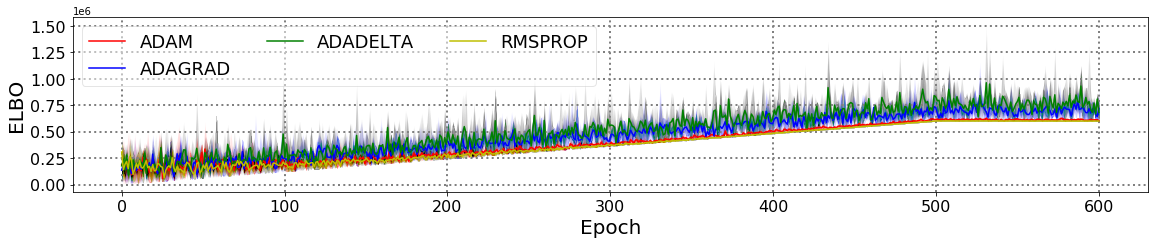

In [95]:
toplotloss = [adam_loss, adagrad_loss,adadelta_loss,rmsprop_loss]
toplotkl = [adam_kl, adagrad_kl]
tsplotseveral(itera,toplotloss, n=100)

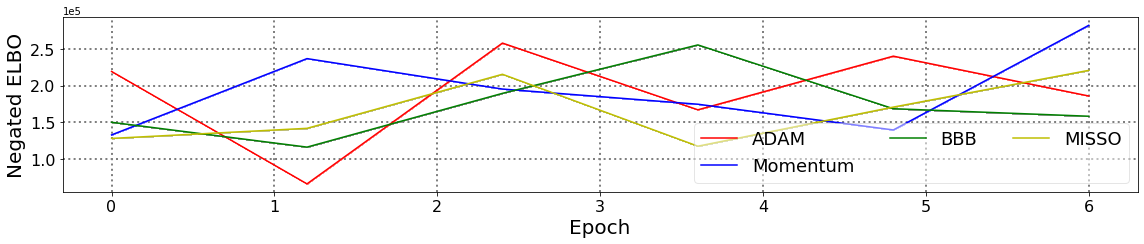

In [55]:
tsplotseveral(itera,[adam,adadelta,adagrad, rmsprop], n=100)